In [1]:
DEBUG = True

### References

<img src="https://static.vecteezy.com/system/resources/previews/000/108/974/original/vector-fashion-girl.jpg" width="700px" />

## Fashion-MNIST Classification

> Can we develop a model that performs well on the Fashion-MNIST dataset?

### Context
Fashion-MNIST is a dataset from Zalando research, comprising of <code>28 x 28</code> grayscale images of a total fo <code>70000</code> fashion products from 10 categories. The intent of this dataset is to serve as a replacement for the MNIST dataset for testing and benchmarking machine learning and deep learning models (Xiao, Rasul and Vollgraf, 2017).

The dataset is based on images from Zalando's assortment. Each original image of <code>762 x 1000</code> in JPEG format was converted to PNG, resized, and then converted to grayscale.

### Objectives
<ol>
	<li>To explore and understand the dataset</li>
	<li>Understand the effects of different data augmentation techniques on the performance of the model</li>
	<li>Develop and experiment with models in order to rival state-of-the-art (SOTA) benchmark scores</li>
</ol>

## Importing libraries
We import the necessary libraries for the notebook to run below.

In [2]:
import math
if not DEBUG:
	from MulticoreTSNE import MulticoreTSNE as TSNE
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set('notebook')
from PIL import Image

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import InterpolationMode
import os

We see the seed such that the notebook results in reproducible results when run. 

We also set the device to CUDA to enable torch to use our GPU.

In [3]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)
if device != torch.device('cuda'):
    print('using cpu, exiting')
    assert False

Device available now: cuda


## Utility Functions
Below we define some utility functions that will ease and help us with our analysis.

In [4]:
def loc_data(data, loc):
	datacopy = copy.deepcopy(data)
	arr = np.array(datacopy.loc[loc].drop('label'))
	label = datacopy.loc[loc]['label']
	root = int(len(arr) ** 0.5)
	arr.resize((root, root))
	return label, arr

def imshow(arr: list, label: list = None, grayscale=True, figsize=None):
	if label == None:
		label = [''] * len(arr)

	height = int(len(arr) ** 0.5)
	width = math.ceil(len(arr) / height)

	if figsize == None:
		fig = plt.figure()
	else:
		fig = plt.figure(figsize=figsize)
	for i in range(height):
		for j in range(width):
			ax = fig.add_subplot(height, width, i * height + j + 1)
			ax.grid(False)
			ax.set_xticks([])
			ax.set_yticks([])
			ax.imshow(arr[i * height + j], cmap='gray' if grayscale else '')
			ax.set_title(label[i * height + j])

def df_to_tensor(df, shape = (28, 28)):
	return torch.tensor(df.values.reshape((-1, *shape)), dtype=torch.float32)


def preprocess(df):
	return df.applymap(lambda x: x / 255)

def mse(t1, t2, shape=(28, 28)):
	loss = nn.MSELoss(reduction='none')
	loss_result = torch.sum(loss(t1, t2), dim=2)
	loss_result = torch.sum(loss_result, dim=2)
	loss_result = loss_result / np.prod([*shape])
	return loss_result

## Dataset
Let's take a look at the dataset. This dataset was retrieved from the original Fashion MNIST dataset found at <a href="https://arxiv.org/pdf/1708.07747v2.pdf">Paper Link</a>. 

<table>
	<tr>
		<th>
			Column Name
		</th>
		<th>
			Description
		</th>
	</tr>
	<tr>
		<td>
			label
		</td>
		<td>
			The true class of the image, represented as an integer ranging from 0 to 9<strong>*</strong>
		</td>
	</tr>
	<tr>
		<td>
			pixel 1<br/>...<br/>pixel 784
		</td>
		<td>
			Pixels representing the image, each pixel ranging from 0 to 255
		</td>
	</tr>
</table>

<strong>\*</strong>Each number represents a certain dress item
```
0 -> T-shirt/top
1 -> Trouser
2 -> Pullover
3 -> Dress
4 -> Coat
5 -> Sandal
6 -> Shirt
7 -> Sneaker
8 -> Bag
9 -> Ankle boot
```

In [5]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's take a look at the training dataset

In [6]:
train = pd.read_csv('data/fashion-mnist_train.csv')
train.shape

(60000, 785)

We observe that there are a total of <code>60000</code> rows and <code>785</code> columns, which is exactly what the original paper mentioned.

### Testing for missing values and invalid data
Let's try to identify if there are any missing values

In [7]:
train.isnull().sum().sum()

0

It appears <strong>no missing values are found</strong>. We will then check for any potential typos.
<ol>
	<li>Firstly, the label should only consist of values from 0 - 9</li>
	<li>Secondly, the pixel values should only fall in between and inclusive of 0 - 255</li>
</ol>

In [8]:
print('Minimum and Maximum values of labels:', train['label'].min(), "and", train['label'].max())
print("Number of values falling outside the range (0 - 255):",
	train.applymap(
		lambda x: x < 0 or x > 255 # True if out of range
	).sum().sum()
)

Minimum and Maximum values of labels: 0 and 9
Number of values falling outside the range (0 - 255): 0


We observe that the dataset seems to be properly cleaned, thus can proceed knowing that <strong>no sign of invalid or missing data have been found.</strong>

### Preprocessing
We'll convert the data such that the range <code>0 - 255</code> becomes <code>0 - 1</code>

In [9]:
train[train.columns[train.columns != 'label']] = preprocess(train[train.columns[train.columns != 'label']])

## Exploratory Data Analysis
In the EDA, we'll be attempting to complete the following set of objectives:

### EDA Objectives
<ol>
	<li>
		Is there any <strong>class imbalance</strong>
	</li>
	<li>
		What does the <strong>average image</strong> look like?
	</li>
	<li>
		Are there <strong>any outliers/anomalies</strong>?
	</li>
</ol>
Before we begin the EDA, we first need to remove a chunk of the training data to be used as validation dataset in order to avoid data leakage due to the decisions we make during EDA.

### Validation Dataset
Let's make our validation dataset. I decided that I will <strong>not be using cross validation during the modelling process</strong> due to the following reasons:
<ul>
	<li>Time taken to train models, especially if utilising <strong>computationally expensive layers, activation functions or architecture</strong></li>
	<li>Additionally due to the sheer size of the dataset, not only does this add to increased training time but also means there is enough data such that cross validation is not necessary</li>
</ul>

We'll use a validation size of <code>10000</code> to mimic the size of the test dataset. We'll also stratify on the <code>label</code> to ensure that the model we generalizes best across all 
the classes.

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('label', axis=1), train['label'], test_size = 10000 / len(train), stratify=train['label'])
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (50000, 784)
X_val shape: (10000, 784)
y_train shape: (50000,)
y_val shape: (10000,)


We see that the data have been split correctly and now we can begin our EDA!

### Signs of class imbalance?
We'll first identify the situation with class imbalance

<AxesSubplot: xlabel='label', ylabel='Count'>

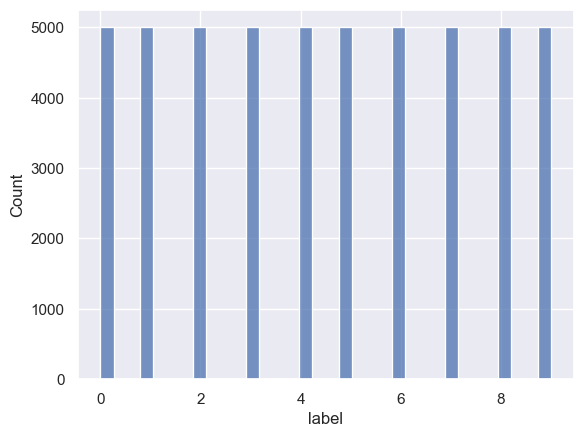

In [11]:
sns.histplot(y_train)

We observe the distribution of labels to be similar for all classes, reaching roughly a count of `5000`. Thus, there is no sign of class imbalance.

### What does the average image look like?
Let's take a look at a random sample of image each first.

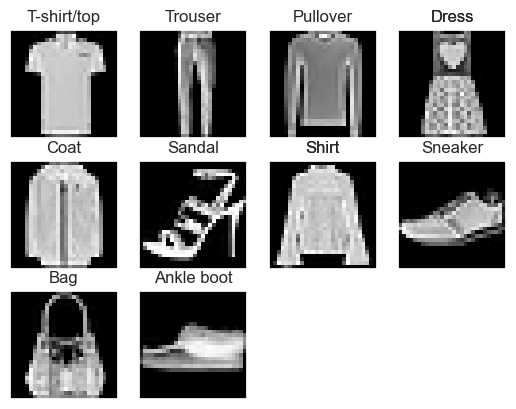

In [12]:
images = []
titles = []

for i in range(10):
	idx = random.sample(list(y_train[y_train == i].index), 1)
	images.append(X_train.loc[idx].values.reshape((28, 28)))
	titles.append(classes[y_train.loc[idx].values[0]])

imshow(images, titles)

We observe that sometimes, there appears to be certain images that are <strong>darker</strong> than others. This suggests that no form of normalization or scaling has been applied to the dataset. Let's take a look at the distribution of brightness to confirm this.

Text(0.5, 0, 'Average Brightness per Image')

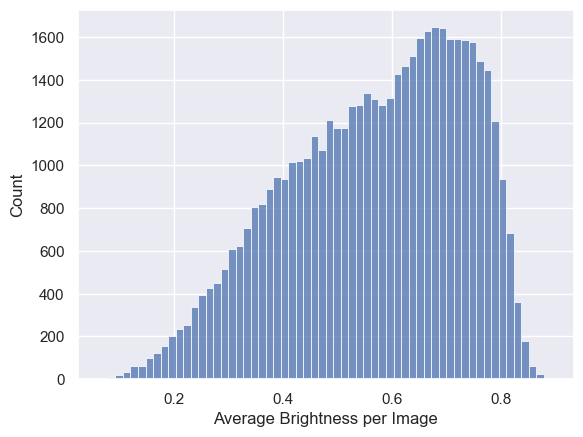

In [13]:
fig = plt.figure()
ax = fig.subplots()

# Note: we want to IGNORE the background of black, filtering by using x != 0
sns.histplot(X_train.apply(lambda x: x[x != 0].mean(), axis=1).values, ax=ax) 
ax.set_xlabel('Average Brightness per Image')

We observe:
<ol>
	<li>
		Most of the images are on the brighter side as we see a large bulk of the distribution going towards the right side.
	</li>
	<li>
		The distribution is skewed to the left, which suggests that we have a few images which are quite dark.
	</li>
</ol>


To find out what the average image looks like, we'll perform an average of the pixels across the different classes.

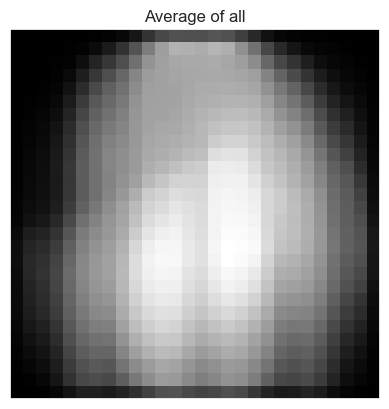

In [14]:
imshow([
	X_train.mean().apply(lambda x: x).values.reshape(28, 28)
], ['Average of all'])

We observe:
<ol>
	<li>The corners of the images are dark/black. This means there is likely no piece of clothing the spreads across the image.</li>
	<li>There is a bright circle-shape in the middle. This tells us most of these images are centered around in the middle</li>
	<li>An <strong>interesting note to point out</strong> is there seems to be some sort of darker 'bar' in the middle, separating the lightest parts of the image.</li>
	<li>
		This may be due to the presence of trousers in the dataset, as from previous images, we can see trousers appears to be the only apparel with such a contrasting stripe in the middle.
	</li>
</ol>

#### Average image among the classes
Next we'll split by the classes and find the average among them.

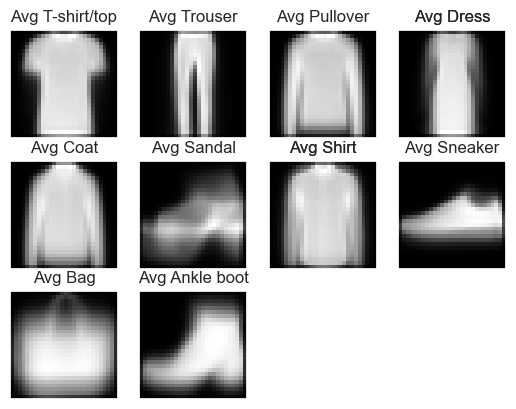

In [15]:
images = []
titles = []

for i in range(10):
	idx = random.sample(list(y_train[y_train == i].index), 1)
	images.append(X_train[y_train == i].mean().apply(lambda x: x).values.reshape(28, 28))
	titles.append(f'Avg {classes[y_train.loc[idx].values[0]]}')

imshow(images, titles)

We observe:
<ol>
	<li>Each type of apparel generally has the same shape</li>
	<li>The most <strong>spread out/least consistent</strong> class seems to be sandals, as seen from the opaque and thicker edges, where as the other types have sharper and lighter borders.</li>
</ol>


### Are there any outliers/anomalies?

We see from the average images, that the piece of clothing in the image are <strong>centered and upright</strong>, in that there are no sort of rotations going on.

As such, let's see if there may be any outlier images, such as rotations or anomaly white spots on the image.

We'll start by visualizing the dataset and seeing if outliers may exist. We can do this using <code>tSNE</code>.

In [16]:
if not DEBUG:
	tsne = TSNE(n_jobs=-1)
	TSNE()
	data_2d = tsne.fit_transform(X_train)

In [17]:
if not DEBUG:
	vis_x = data_2d[:, 0]
	vis_y = data_2d[:, 1]
	plt.scatter(vis_x, vis_y, c=y_train, cmap=plt.cm.get_cmap("jet", 10), marker='.')
	cbar = plt.colorbar(ticks=range(10))
	cbar.set_ticks([])
	for j, lab in enumerate(classes):
		cbar.ax.text(1.5, j, f'${lab}$', ha='left', va='center')

	cbar.ax.get_yaxis().labelpad = 15

	plt.clim(-0.5, 9.5)
	plt.title('Clustering Visualization with 2 components')
	plt.show()

TSNE produces an <strong>incredibly interesting visualization</strong>. We observe:
<ol>
	<li>
		There is a large breakoff of clusters at the top right. Taking a look at the classes we see that they are <code>Sneaker</code>, <code>Ankleboot</code> and <code>Sandal</code>, which are all types of footwear. 
	</li>
	<li>
		Within the footwear cluster, we recognise the classes are separated distinctly, with quite sharp edges. 
	</li>
	<li>
		The large cluster in the middle contains <code>pullover</code>, <code>dress</code>, <code>t-shirt</code> and <code>shirt</code>. This cluster seems to represent the upper body clothing.
	</li>
	<li>
		In this center cluster, the classes do not have distinct edges, but <strong>rather seem to mix and mingle together</strong>. This suggests that <code>TSNE with 2 components was unable</code> to separate these classes.
	</li>
	<li>
		Lastly, the cluster at the bottom left represents <code>bag</code>. We recognise a distinct split in the center of the cluster, suggesting that there are two types of bags.
	</li>
	<li>
		Looking at the top right cluster, we recognise some red and blue data points in the wrong cluster. This may suggest <strong>presence of outliers</strong>. Let's try to identify outliers and see how we can deal with them.
	</li>
</ol>

### Using Autoencoders to identify anomalies
The idea behind this is that we can use an autoencoder to some what <strong>compress</strong> the image, or restrict the image to its most important features. We'll train this autoencoder on minimising MSE with the original image, thus the autoencoder will learn to capture the more generic and most important features. 

Thus, after an anomaly has been passed through this autoencoder, we expect the MSE to be quite high as the anomaly image does not follow the general 'style' of the images in the dataset.

#### Defining the AutoEncoder architecture
We'll use a <strong>Convolutional Auto Encoder architecture</strong>, which is better able to extract features from images. This is because artificial neural networks do not account for proximity of each pixel to other pixels.

In [18]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, stride=2),
            nn.LeakyReLU(),

            nn.Conv2d(8, 16, 3, padding=1, stride=2),
            nn.LeakyReLU(),

            nn.Conv2d(16, 32, 3, padding=0, stride=2),
            nn.LeakyReLU(),
        )

        self.hidden = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(32 * 3 * 3, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 32 * 3 * 3),
            nn.LeakyReLU(),
            nn.Unflatten(1, torch.Size([32, 3, 3]))
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, output_padding=0, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 8, 3, padding=1, output_padding=1, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 1, 3, padding=1, output_padding=1, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.hidden(x)
        x = self.decoder(x)

        return x

Now that we have set up the architecture, we can instantiate the model, optimizers and criterion. To train the autoencoder, we'll be using <strong>mean squared error</strong> loss.

$$MSE = \frac{1}{n ^ 2}\sum_{i = 0}^{n}\sum_{j = 0}^{n}(X_{ij} - \hat{X}_{ij}) ^ 2$$

where $X_{ij}$ is the true value of the pixel at the $\text{i'th}$ row and $\text{j'th}$ column and   
$\hat{X}_{ij}$ is the reconstructed value of the pixel at the $\text{i'th}$ row and $\text{j'th}$ column

This is because any pixel that <strong>stands out/is an anomaly</strong> will have a <strong>heavily influence</strong> on the loss <strong>due to the square in the loss function</strong>.

In [19]:
model = ConvAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

#### Loading the dataset
Next we need to load the dataset. In order to do this, below is a custom class that acts as a wrapper <strong>to convert a pandas dataframe to PyTorch tensors</strong>, such that we are able to load the dataset into the <code>DataLoader</code> class.

In [20]:
def to_prob_dist(labels: torch.tensor, size = 10):
	arr = np.full((len(labels), size), 0)
	for i, label in enumerate(labels):
		arr[i][int(label.item())] = 1
	return torch.tensor(arr, dtype=torch.float32)


class TorchDataset():
	def __init__(self, X, y, X_shape = (1, 28, 28), y_shape = (1, )):
		self.x = df_to_tensor(X, X_shape).to(device)
		self.y = df_to_tensor(y, y_shape)

		# Transform labels to probability distributions
		self.y = to_prob_dist(self.y).to(device)
	
	def __len__(self):
		return len(self.y)

	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]

train_loader = DataLoader(TorchDataset(X_train, y_train), batch_size=64, shuffle=True)

#### Training the Convolutional Auto Encoder
We can now train the auto encoder.

In [21]:
# number of epochs to train the model
if not DEBUG:
    n_epochs = 100

    track_loss = []

    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0
        
        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data
            images = images.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)
                
        # print avg training statistics 
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
        ))
        track_loss.append(train_loss)

    track_loss_df = pd.DataFrame({'epoch': np.arange(1, len(track_loss) + 1), 'loss': track_loss})
    sns.lineplot(track_loss_df, x = 'epoch', y = 'loss')

#### Interpretting the results
Let's take a look at how the autoencoder works

In [22]:
if not DEBUG:
	image = df_to_tensor(X_train.iloc[0], (1, 28, 28))
	image = image.to(device)
	encoder_output = model.encoder(image)
	model_output = model(image)
	imshow([image.cpu().numpy()[0, 0], encoder_output.cpu().detach().numpy()[0, 0], model_output.cpu().detach().numpy()[0, 0]], ['Original', 'Encoder', 'AutoEncoder'])

Now that we have a trained and working autoencoder, let's use it to identify any anomalies.

In [23]:
if not DEBUG:
	images = df_to_tensor(X_train, (1, 28, 28))
	images = images.to(device)
	outputs = model(images)

Let's take a look at the <code>99.95'th percentile</code>.

In [24]:
if not DEBUG:
	errors = mse(outputs, images).detach().cpu().numpy().flatten()
	error_boolean = errors > np.percentile(errors, 99.95)

	imshow(X_train.iloc[error_boolean].values.reshape((-1, 28, 28)))

We observe:
<ol>
	<li>
	</li>
</ol>

### Hypothesis: Footwear images only point to the left

From a view glimpses of footwear classes, we begin to recognise that it seems that all the images point to the left direction: in that the 'pointy' tip of the footwear is at the left and the heel is at the right.

Here, let's take a look at 36 randomly sampled footwear.

#### Random sampling

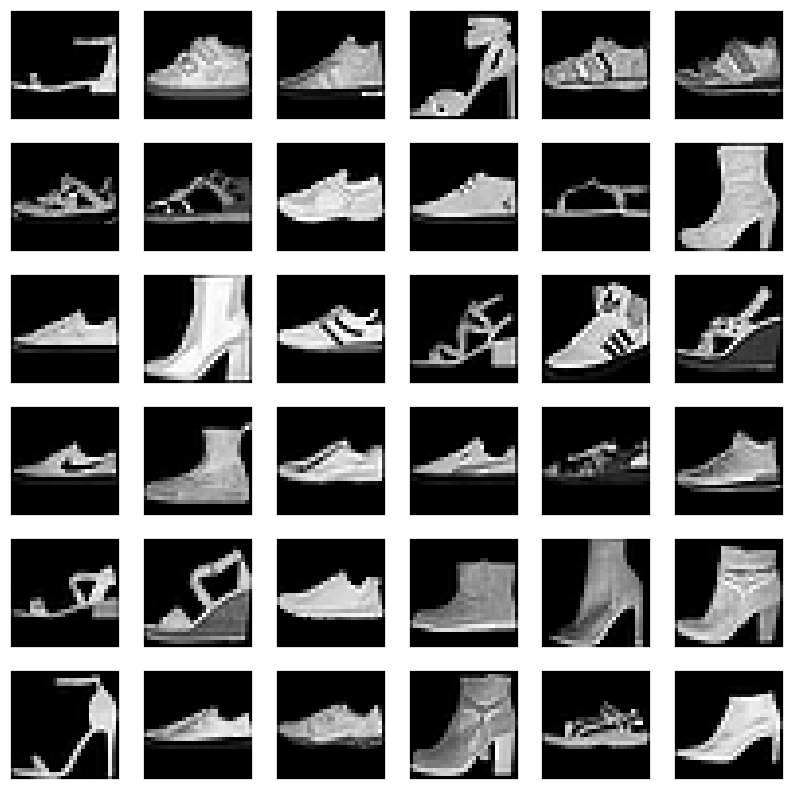

In [25]:
is_footwear = np.isin(y_train.values, [5, 7, 9])
footwear_images = X_train[is_footwear]

imshow(
	footwear_images.sample(36).values.reshape((-1, 28, 28)),
	figsize=(10, 10)
)

#### Custom Slope Algorithm for Footwear Images

To test the orientation of footwear (i.e. whether it's pointed to the left or right), we can use a slope detection algorithm.

The idea for this algorithm is below: 

```
[
	[0, 0, 0, 0, 0],
	[0, 0, 0, 1, 1],
	[0, 1, 1, 1, 1],
	[1, 1, 1, 1, 0],
	[0, 0, 0, 0, 0]
]
```

Suppose the above <code>5x5</code> is an image of our shoe. For each column, we'll find the first position where there is a non-zero value.

So for the first column it would here:

```
[
	[0, 0, 0, 0, 0],
	[0, 0, 0, 1, 1],
	[0, 1, 1, 1, 1],
	[*1*, 1, 1, 1, 0],
	[0, 0, 0, 0, 0]
]
```

For second column it would here:

```
[
	[0, 0, 0, 0, 0],
	[0, 0, 0, 1, 1],
	[0, *1*, 1, 1, 1],
	[1, 1, 1, 1, 0],
	[0, 0, 0, 0, 0]
]
```

Doing this will give us something we can call a <strong>height</strong>. For the above image, our height would be:
<code>[2, 3, 3, 4, 4]</code>

From this, we can simply determine the direction in which the slant goes. If the slant goes from low to high, it is pointed to the left, otherwise, it is pointed to the right

In [26]:
def is_left_pointed(arr):
	arr = np.array(arr)
	greater = np.where(arr.T > 0) # Gives us all index positions for non zero values
	greater_df = pd.DataFrame(greater).T # A dataframe where the first column is the column position, and the second column is the row index for non-zero values

	# We will then group by the first column (column), finding the max height for each column
	Y = len(arr) - greater_df.groupby(0).agg('min').values.flatten()
	X = np.arange(0, len(Y))
	slope = np.polyfit(X,Y,1)[0]
	return slope > 0

if not DEBUG:
	mylist = footwear_images.values.reshape((-1, 28, 28)).tolist()
	result = np.array(list(map(is_left_pointed, mylist)))

In [27]:
if not DEBUG:
	imshow(footwear_images.values.reshape((-1, 28, 28))[result == False][0:49], figsize=(10, 10))

In [28]:
torch.cuda.current_device()

0

We observe:
<ul>
	<li><strong>Most of these footwear appear to be slippers</strong>. This makes sense as our algorithm looks for the slope, which the slipper is different from something like a shoe.</li>
	<li>
		<strong>We also see images of footwear pointing to the right.</strong>
	</li>
</ul>

Thus we conclude that when performing data augmentation, we should remember to horizontally flip as well.

## Feature Engineering

We have performed feature engineering during the <strong>preprocessing step</strong>, where we divided all the values of the pixels by 255

## Data Augmentation

Data augmentation is a technique used to increase the amount of data by adding slightly modified copies of existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model (Shorten and Khoshgoftaar, 2019).

As such, performing data augmentation is likely to have a positive impact on our model performance, if our model overfits.

### Basic
For our basic augmentation, I decided to perform the following transformations:
<ul>
	<li>
		<strong>RandomHorizontalFlip</strong> - this is due to the different directions the image would 'point' as seen from our EDA
	</li>
	<li>
		<strong>RandomRotation</strong> - The goal here is not to rotate by 90 degrees, but to make slight adjustments of angles such that the model becomes more robust.
	</li>
	<li>
		<strong>RandomAffine</strong> - We'll be using affine to <strong>sheer</strong> the images in the y-direction. 
	</li>
</ul>

I realised there was no need to perform cropping augmentation, as working with the dataset has shown me that the images show the item fully.

In [29]:
t_flip = transforms.RandomHorizontalFlip(p=1)
t_rotate = transforms.RandomRotation((-5, 5))


t_shear = transforms.RandomChoice([
	transforms.RandomAffine(0, shear = (-10, 10, -10, 10), interpolation=InterpolationMode.NEAREST)
])

t_basic = transforms.RandomOrder([
	t_flip, t_rotate, t_shear
])

Below we see how each transformation contributes to the final image.

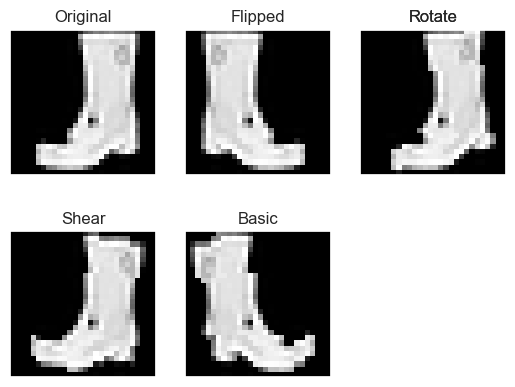

In [30]:
sample_img = copy.deepcopy(df_to_tensor(X_train.iloc[2]))
imshow([
	sample_img[0],
	t_flip(copy.deepcopy(sample_img))[0],
	t_rotate(copy.deepcopy(sample_img))[0],
	t_shear(copy.deepcopy(sample_img))[0],
	t_basic(copy.deepcopy(sample_img))[0],
], ['Original', 'Flipped', 'Rotate', 'Shear', 'Basic'])

### RandomErasing
An additionally method of augmentation we can try is <strong>RandomErasing</strong>. RandomErasing is a data augmentation technique which randomly selects a rectangular region of the image and erases those pixels with random values. (Zhong et al., 2017)

Let's take a look:

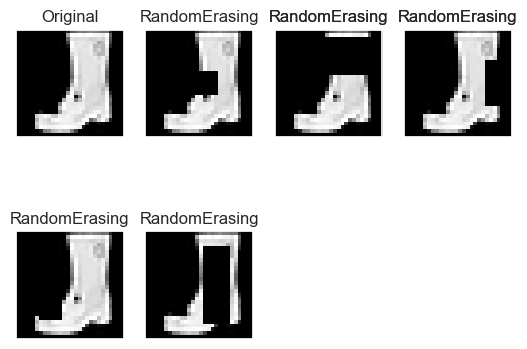

In [31]:
t_erase = transforms.RandomErasing(p = 1)

imshow([
	sample_img[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
	t_erase(copy.deepcopy(sample_img))[0],
], ['Original', 'RandomErasing', 'RandomErasing', 'RandomErasing', 'RandomErasing', 'RandomErasing', 'RandomErasing'])

As random erasing is used on top of basic augmentation, we'll make a compose transformer of the two.

In [32]:
t_erase = transforms.Compose([
	t_basic,
	transforms.RandomErasing(p = 1)
])

## Modelling

### Metric
We'll be using two metrics: <strong>Accuracy</strong> and <strong>Categorical Crossentropy</strong>

$$accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

$$\text{categorical crossentropy} = -\sum_{i=1}^{n}y_i \log{(p_i)} $$

We use accuracy to choose the model, as the benchmarks for the Fashion MNIST dataset are in terms of accuracy. Additionally, the dataset does not have an imbalanced class issue, thus using accuracy is not unsuitable.

We use categorical crossentropy as our criterion to train the model, because it heavily penalizes models that are confident and wrong in their prediction. This is due to the logarithmic function in the cross entropy formula. 

### Set up training environment
Let's set up the necessary details for our training to begin. Firstly, <strong>we define our datasets below</strong>.

In [33]:
def perform_augmentation(torch_dataset: TorchDataset, transform):
	data_copy = copy.deepcopy(torch_dataset)
	X = copy.deepcopy(data_copy.x)
	transformed = transform(X)
	data_copy.x = torch.cat((X, transformed), dim = 0)
	return data_copy

train_data = TorchDataset(X_train, y_train)
val_data = TorchDataset(X_val, y_val)
train_augmented_erase = perform_augmentation(TorchDataset(X_train, y_train), t_erase)

#### Custom Early Stopping
Additionally, instead of <strong>arbitrarily choosing the number of epochs</strong> or fine tuning it (which computationally will take long), I decided to use <strong>Early Stopping</strong> as a mechanism.

Overfitting is something that occurs when a model begins to extract some of the residual variation such as noise under the assumption that it is learning the patterns (Burnham and Anderson, 2010). Essentially, it starts to <strong>memorize instead of generalize</strong>. Traditional Early Stopping attempts to combat overfitting by stopping training if the performance/loss of the model on a validation set does not improve over $n$ epochs, where $n$ is the patience parameter. However, it requires <strong>clever tuning</strong> to prevent underfitting (Adam, 2018). As such to address this problem, I use a custom implemented early stopping class inspired by this <a href="https://alexadam.ca/2018/08/03/early-stopping/">article</a>.

The idea of this custom early stopping is that we <strong>only stop training</strong> if there are no improvements in <strong>both loss and accuracy</strong>. If there is an improve in any of the single quantities, the patience counter is reset. This tackles the issue of the underlying assumption that <strong>"loss is correlated with accuracy</strong>", and becomes a more lenient form of early stopping, ideally decreasing underfitting.

In [34]:
class CustomEarlyStopping():
	def __init__(self, patience, extra_train = 0, min_loss_delta = 0, min_acc_delta = 0):
		self.patience = patience
		self.best_loss = 1e9
		self.best_acc = 0
		self.patience_count = 0
		self.count = 0
		self.extra_train = extra_train
		self.extra_train_start = False
		self.stop = False

		self.min_loss_delta = min_loss_delta
		self.min_acc_delta = min_acc_delta

	def __call__(self, loss, accuracy):
		self.save_state = False
		if self.best_loss - loss > self.min_loss_delta or accuracy - self.best_acc > self.min_acc_delta:
			if self.best_loss - loss > self.min_loss_delta:
				self.best_loss = loss
			if accuracy - self.best_acc > self.min_acc_delta:
				self.best_acc = accuracy

			self.count = 0
		else:
			self.count += 1
		
		if self.count >= max(self.patience, self.extra_train):
			self.stop = True

#### Trainer
To help us with training and determining the best models, we set up a trainer that will <strong>keep track of our models</strong> and <strong>ease the modelling process</strong>.

In [55]:
def accurate_count(pred, true):
	return ((pred.argmax(dim=1) == true.argmax(dim=1)).sum()).item()

	
class Trainer():
	def __init__(self, val_data, criterion):
		self.saves = {}
		self.loss_tracker = {}
		self.history = pd.DataFrame()
		self.val_data = val_data

	def show_history(self):
		pass

	def train_model(self, name, model_pass, optimizer_pass, optimizer_args, train_data: TorchDataset, scheduler_pass = None, scheduler_args = None, batch_size = 64, early_stopping = None, epochs = 200, verbose = False):
		model = model_pass().to(device)
		optimizer = optimizer_pass(model.parameters(), **optimizer_args)
		train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
		val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)

		if scheduler_pass != None:
			scheduler = scheduler_pass(optimizer, **scheduler_args)

		done = 0
		n_epochs = epochs
		
		track_loss = np.full((epochs, 4), 0.0, dtype=np.float32) # train acc, train loss, val acc, val loss

		best_performance_df = pd.DataFrame({'Train Loss': 1000, 'Val Loss': 1000, 'Train Acc': 0, 'Val Acc': 0}, index = [name])
		best_val_loss = 1e9

		self.end_training = 0
		self.extra_trained = 0

		for epoch in range(1, n_epochs+1):
			# monitor training loss
			train_loss = 0.0
			train_acc_count = 0
			total_sample = 0
			
			###################
			# train the model #
			###################
			for data in train_loader:
				# _ stands in for labels, here
				# no need to flatten images
				inputs, labels = data
				inputs = inputs.cuda()
				labels = labels.cuda()
				# clear the gradients of all optimized variables
				optimizer.zero_grad()
				# forward pass: compute predicted outputs by passing inputs to the model
				outputs = model(inputs)
				# calculate the loss
				loss = criterion(outputs, labels)
				# backward pass: compute gradient of the loss with respect to model parameters
				loss.backward()
				# perform a single optimization step (parameter update)
				optimizer.step()
				if scheduler_pass != None:
					scheduler.step()
				# update running training loss
				train_loss += loss.item() * inputs.size(0)
				train_acc_count += accurate_count(outputs, labels)
				total_sample += len(labels)
					
			# print avg training statistics 
			train_loss = train_loss/len(train_loader)
			train_acc = train_acc_count / total_sample

			val_loss = 0.0
			val_acc_count = 0
			total_sample = 0
			for i, data in enumerate(val_loader):
				inputs, labels = data                             
				inputs = inputs.to(device)
				labels = labels.to(device)
																
				outputs = model(inputs)                           
				loss = criterion(outputs, labels)                 

				val_loss += loss.item() * inputs.size(0)
				val_acc_count += accurate_count(outputs, labels)
				total_sample += len(labels)

			val_loss = val_loss / len(val_loader)
			val_acc = val_acc_count / total_sample

			if verbose:
				print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} \tVal Loss: {val_loss:.5f} \tTrain Acc: {train_acc:.3f} \tVal Acc: {val_acc:.3f}")

			track_loss[epoch - 1][0] = train_acc
			track_loss[epoch - 1][1] = train_loss
			track_loss[epoch - 1][2] = val_acc
			track_loss[epoch - 1][3] = val_loss
			done = epoch

			if val_loss < best_val_loss or (early_stopping != None and early_stopping.extra_train_start):
				best_performance_df = pd.DataFrame({'Train Loss': train_loss, 'Val Loss': val_loss, 'Train Acc': train_acc, 'Val Acc': val_acc}, index = [name])
				self.end_training = epoch
				best_val_loss = val_loss
				self.save_model(name, model)

			early_stopping(val_loss, val_acc)

			if early_stopping.count == early_stopping.extra_train:
				self.extra_trained = epoch
				best_performance_df = pd.DataFrame({'Train Loss': train_loss, 'Val Loss': val_loss, 'Train Acc': train_acc, 'Val Acc': val_acc}, index = [name])
				self.save_model(name, model)

			if early_stopping != None and early_stopping.stop:
				if (verbose):
					print(f"Stopping due to early stopping | patience = {early_stopping.patience}, extra_train = {early_stopping.extra_train}")
				break

		track_loss.resize((done, 4))
		self.record(name, track_loss, best_performance_df)

	def record(self, name, track_loss, best_performance_df):
		track_loss_df = pd.DataFrame(track_loss, columns=['Train Acc', 'Train Loss', 'Val Acc', 'Val Loss'])
		track_loss_df.index += 1
		track_loss_df.index.name = 'Epoch'

		self.history = pd.concat([self.history, best_performance_df], axis=0)
		self.loss_tracker[name] = track_loss_df

	def save_model(self, name, model):
		self.saves[name] = copy.deepcopy(model)

	def get_model(self, name):
		return copy.deepcopy(self.saves[name])

	def archive(self, name):
		fig = plt.figure(figsize=(14, 5))
		train, val = sns.color_palette('Set2')[0:2]
		loss, acc = fig.subplots(1, 2)

		loss.axvspan(1, self.end_training, color=sns.color_palette('Paired')[0], alpha=0.4, lw=0, label='Training') 
		if self.extra_trained != self.end_training:
			loss.axvspan(self.end_training, self.extra_trained, color=sns.color_palette('Set2')[3], alpha=0.2, lw=0, label='Extra Train') 

		loss.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Train Loss'], label='Train', color=train)
		loss.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Val Loss'], label='Val', color=val)
		loss.set_xlabel('Epoch')
		loss.set_ylabel('Loss')

		acc.axvspan(1, self.end_training, color=sns.color_palette('Paired')[0], alpha=0.4, lw=0, label='Training') 
		acc.axvspan(self.end_training, self.extra_trained, color=sns.color_palette('Set2')[3], alpha=0.2, lw=0, label='Extra Train') 
		acc.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Train Acc'], label='Train', color=train)
		acc.plot(self.loss_tracker[name].index, self.loss_tracker[name]['Val Acc'], label='Val', color=val)

		acc.set_xlabel('Epoch')
		acc.set_ylabel('Accuracy')

		acc.legend()
		loss.legend()
		
		fig.savefig(f'plots/{name}.png')
		plt.close()
		del self.loss_tracker[name]

We instantiate our trainer with our validation data, along with our loss function: <strong>categorical crossentropy</strong>

In [56]:
trainer = Trainer(val_data, nn.CrossEntropyLoss)

### Model Architectures
We can now get started with determining the best non-fine-tuned model to proceed with.

#### Baseline - NN
As our baseline, we'll use a simple neural network consisting of:
<ol>
<li>Linear layer</li>
<li>Batch Normalization</li>
<li>ReLU</li>
</ol>

In [57]:
class BaseNN(nn.Module):
    def __init__(self):
        super(BaseNN, self).__init__()

        self.flat = nn.Flatten(1)

        self.fc1 = nn.Linear(784, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc1_act = nn.ReLU()

        self.fc2 = nn.Linear(256, 64)
        self.fc2_bn = nn.BatchNorm1d(64)
        self.fc2_act = nn.ReLU()

        self.fc3 = nn.Linear(64, 16)
        self.fc3_bn = nn.BatchNorm1d(16)
        self.fc3_act = nn.ReLU()

        self.fc4 = nn.Linear(16, 10)
        self.fc4_bn = nn.BatchNorm1d(10)
        self.fc4_act = nn.ReLU()

    def get_logits(self, x):
        x = self.flat(x)
        x = self.fc1_act(self.fc1_bn(self.fc1(x)))
        x = self.fc2_act(self.fc2_bn(self.fc2(x)))
        x = self.fc3_act(self.fc3_bn(self.fc3(x)))
        x = self.fc4_act(self.fc4_bn(self.fc4(x)))
        logits = x
        return logits

    def forward(self, x):
        logits = self.get_logits(x)
        return nn.functional.softmax(logits, dim=1)

In [58]:
trainer.train_model(
	'Baseline NN', BaseNN, # model
	optim.Adam, {'lr': 1e-3}, # optimizer
	train_data, # data
	early_stopping = CustomEarlyStopping(patience = 10),
	verbose=True
)
trainer.archive('Baseline NN')
display(trainer.history)

Epoch: 1 | Train Loss: 1.94348 	Val Loss: 1.53893 	Train Acc: 0.819 	Val Acc: 0.849
Epoch: 2 | Train Loss: 1.41372 	Val Loss: 1.33430 	Train Acc: 0.858 	Val Acc: 0.862
Epoch: 3 | Train Loss: 1.26420 	Val Loss: 1.27692 	Train Acc: 0.871 	Val Acc: 0.865
Epoch: 4 | Train Loss: 1.17699 	Val Loss: 1.21823 	Train Acc: 0.878 	Val Acc: 0.870
Epoch: 5 | Train Loss: 1.11185 	Val Loss: 1.20727 	Train Acc: 0.885 	Val Acc: 0.872
Epoch: 6 | Train Loss: 1.04871 	Val Loss: 1.17411 	Train Acc: 0.891 	Val Acc: 0.876
Epoch: 7 | Train Loss: 1.00926 	Val Loss: 1.11125 	Train Acc: 0.896 	Val Acc: 0.883
Epoch: 8 | Train Loss: 0.94994 	Val Loss: 1.14540 	Train Acc: 0.901 	Val Acc: 0.878
Epoch: 9 | Train Loss: 0.91468 	Val Loss: 1.08080 	Train Acc: 0.906 	Val Acc: 0.885
Epoch: 10 | Train Loss: 0.88480 	Val Loss: 1.11015 	Train Acc: 0.909 	Val Acc: 0.883
Epoch: 11 | Train Loss: 0.84995 	Val Loss: 1.06026 	Train Acc: 0.913 	Val Acc: 0.890
Epoch: 12 | Train Loss: 0.81243 	Val Loss: 1.12482 	Train Acc: 0.916 	Val 

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,0.456521,1.025482,0.95504,0.8967


<img src="plots/Baseline NN.png">

We observe:
<ul>
	<li>Despite using early stopping, we can identify <strong>large amounts of overfitting</strong></li>
	<li>This suggests not that early stopping is bad, but using this model means we allow the model to overfit, <strong>as long as the validation is improving.</strong></li>
	<li>This means that training is perhaps inefficient but not terrible, as for each epoch, <strong>we learn more noise than pattern</strong></li>
	<li>With a patience parameter of <code>10</code>, Early Stopping has stopped our training at <strong>Epoch = 20</strong></li>
	<li>Surprisingly, the baseline performance is impressive for a basic model at 0.89 accuracy</strong>
</ul>

#### Augmentation + Baseline NN

In [59]:
trainer.train_model(
	'Baseline NN + Aug_Erase', BaseNN, # model
	optim.Adam, {'lr': 1e-3}, # optimizer
	train_augmented_erase, # data
	early_stopping = CustomEarlyStopping(patience = 10),
	verbose=False
)
trainer.archive('Baseline NN + Aug_Erase')
display(trainer.history)

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,0.456521,1.025482,0.95504,0.8967
Baseline NN + Aug_Erase,0.696370,1.037000,0.92906,0.8922


We observe:

#### Convolutional Neural Networks (CNN)

Convolutional Neural Networks (also known as ConvNets or CNNs) is a class of neural networks, with its most popular use case being in analyzing visual imagery (Valueva et al., 2020).

We'll use the LNet architecture.

In [60]:
class LeNet(nn.Module):
	def __init__(self):
		super(LeNet, self).__init__()

		self.conv1 = nn.Conv2d(1, 6, 5, padding = 2)
		self.sig1 = nn.Sigmoid()
		self.pool1 = nn.AvgPool2d(2, stride=2)

		self.conv2 = nn.Conv2d(6, 16, 5, padding = 0)
		self.sig2 = nn.Sigmoid()
		self.pool2 = nn.AvgPool2d(2, stride=2)

		self.flat = nn.Flatten(start_dim=1)

		self.fc1 = nn.Linear(16 * 5 * 5, 120)
		self.sig_fc1 = nn.Sigmoid()

		self.fc2 = nn.Linear(120, 84)
		self.sig_fc2 = nn.Sigmoid()

		self.fc3 = nn.Linear(84, 10)

	def forward(self, x):
		x = self.pool1(self.sig1(self.conv1(x)))
		x = self.pool2(self.sig2(self.conv2(x)))
		x = self.flat(x)
		x = self.sig_fc1(self.fc1(x))
		x = self.sig_fc2(self.fc2(x))
		x = self.fc3(x)
		return x

In [61]:
trainer.train_model(
	'LeNet', LeNet, # model
	optim.Adam, {'lr': 1e-3, 'weight_decay': 1e-5}, # optimizer
	train_data, # data
	early_stopping = CustomEarlyStopping(patience = 10),
	verbose=True
)
trainer.archive('LeNet')
display(trainer.history)


Epoch: 1 | Train Loss: 4.62074 	Val Loss: 2.83612 	Train Acc: 0.383 	Val Acc: 0.683
Epoch: 2 | Train Loss: 2.44886 	Val Loss: 2.19699 	Train Acc: 0.730 	Val Acc: 0.754
Epoch: 3 | Train Loss: 2.06238 	Val Loss: 1.95525 	Train Acc: 0.773 	Val Acc: 0.785
Epoch: 4 | Train Loss: 1.86615 	Val Loss: 1.80974 	Train Acc: 0.799 	Val Acc: 0.812
Epoch: 5 | Train Loss: 1.72872 	Val Loss: 1.68213 	Train Acc: 0.818 	Val Acc: 0.822
Epoch: 6 | Train Loss: 1.62138 	Val Loss: 1.54109 	Train Acc: 0.832 	Val Acc: 0.839
Epoch: 7 | Train Loss: 1.53386 	Val Loss: 1.47360 	Train Acc: 0.841 	Val Acc: 0.845
Epoch: 8 | Train Loss: 1.47403 	Val Loss: 1.43737 	Train Acc: 0.848 	Val Acc: 0.849
Epoch: 9 | Train Loss: 1.41943 	Val Loss: 1.39682 	Train Acc: 0.853 	Val Acc: 0.855
Epoch: 10 | Train Loss: 1.37453 	Val Loss: 1.34263 	Train Acc: 0.858 	Val Acc: 0.859
Epoch: 11 | Train Loss: 1.33526 	Val Loss: 1.32805 	Train Acc: 0.861 	Val Acc: 0.860
Epoch: 12 | Train Loss: 1.30273 	Val Loss: 1.27564 	Train Acc: 0.865 	Val 

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,0.456521,1.025482,0.95504,0.8967
Baseline NN + Aug_Erase,0.696370,1.037000,0.92906,0.8922
LeNet,0.625906,0.875531,0.93792,0.9080


#### Augmentation + CNN

In [63]:
trainer.train_model(
	'LeNet + Aug_Erase', LeNet, # model
	optim.Adam, {'lr': 1e-3, 'weight_decay': 1e-5}, # optimizer
	train_augmented_erase, # data
	early_stopping = CustomEarlyStopping(patience = 10),
	verbose=True
)
trainer.archive('LeNet + Aug_Erase')
display(trainer.history)

Epoch: 1 | Train Loss: 4.30508 	Val Loss: 2.75997 	Train Acc: 0.439 	Val Acc: 0.714
Epoch: 2 | Train Loss: 2.39405 	Val Loss: 2.13803 	Train Acc: 0.737 	Val Acc: 0.761
Epoch: 3 | Train Loss: 2.04388 	Val Loss: 1.90449 	Train Acc: 0.776 	Val Acc: 0.795
Epoch: 4 | Train Loss: 1.85376 	Val Loss: 1.74580 	Train Acc: 0.801 	Val Acc: 0.808
Epoch: 5 | Train Loss: 1.72370 	Val Loss: 1.69137 	Train Acc: 0.817 	Val Acc: 0.820
Epoch: 6 | Train Loss: 1.63304 	Val Loss: 1.59165 	Train Acc: 0.828 	Val Acc: 0.830
Epoch: 7 | Train Loss: 1.54890 	Val Loss: 1.50688 	Train Acc: 0.838 	Val Acc: 0.842
Epoch: 8 | Train Loss: 1.48808 	Val Loss: 1.44824 	Train Acc: 0.844 	Val Acc: 0.847
Epoch: 9 | Train Loss: 1.43641 	Val Loss: 1.40276 	Train Acc: 0.850 	Val Acc: 0.852
Epoch: 10 | Train Loss: 1.38355 	Val Loss: 1.34401 	Train Acc: 0.857 	Val Acc: 0.859
Epoch: 11 | Train Loss: 1.34013 	Val Loss: 1.30356 	Train Acc: 0.860 	Val Acc: 0.863
Epoch: 12 | Train Loss: 1.30382 	Val Loss: 1.28924 	Train Acc: 0.865 	Val 

,Train Loss,Val Loss,Train Acc,Val Acc
Baseline NN,0.456521,1.025482,0.95504,0.8967
Baseline NN + Aug_Erase,0.696370,1.037000,0.92906,0.8922
LeNet,0.625906,0.875531,0.93792,0.9080
LeNet + Aug_Erase,0.436945,0.869134,0.96060,0.9143


We observe:

#### ResNet

In [138]:
def relu_bn_conv(in_channels, out_channels, **kwargs):
	return nn.Sequential(
		nn.Conv2d(in_channels, out_channels, **kwargs),
		nn.BatchNorm2d(out_channels),
		nn.ReLU()
	)

class ResBlock(nn.Module):
	def __init__(self, in_channels, out_channels, skip = False):
		super().__init__()
		self.skip = nn.Sequential()
		self.conv1 = relu_bn_conv(in_channels, out_channels, kernel_size = 3, padding = 1)

		if skip:
			self.conv1 = relu_bn_conv(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)
			self.skip = nn.Conv2d(in_channels, out_channels, kernel_size= 1, stride = 2)

		self.conv2 = relu_bn_conv(out_channels, out_channels, kernel_size = 3, padding = 1)

	def forward(self, x):
		skip = self.skip(x)
		x = self.conv1(x)
		x = self.conv2(x)
		x = x + skip
		return nn.ReLU()(x)

In [141]:
class ScaledResNet(nn.Module):
	def __init__(self, base_filter = 8):
		super().__init__()

		in_channels = 1
		
		self.l0 = nn.Sequential(
			nn.Conv2d(in_channels, base_filter, kernel_size = 7, stride = 2, padding = 3),
			nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
			nn.BatchNorm2d(base_filter),
			nn.ReLU()
		)
		self.l1 = nn.Sequential(
			ResBlock(base_filter, base_filter, skip = False),
			ResBlock(base_filter, base_filter, skip = False),
		)
		self.l2 = nn.Sequential(
			ResBlock(base_filter, base_filter * 2, skip = True),
			ResBlock(base_filter * 2, base_filter * 2, skip = False),
		)
		self.l3 = nn.Sequential(
			ResBlock(base_filter * 2, base_filter * 3, skip = True),
			ResBlock(base_filter * 3, base_filter * 3, skip = False),
		)
		self.l4 = nn.Sequential(
			ResBlock(base_filter * 3, base_filter * 4, skip = True),
			ResBlock(base_filter * 4, base_filter * 4, skip = False),
		)
		self.gap = torch.nn.AdaptiveAvgPool2d(1)
		self.fc = nn.Sequential(
			nn.Flatten(start_dim=1),
			torch.nn.Linear(base_filter * 4, 10)
		)

	def forward(self, x):
		x = self.l0(x)
		x = self.l1(x)
		x = self.l2(x)
		x = self.l3(x)
		x = self.l4(x)
		x = self.gap(x)
		x = self.fc(x)

		return x

In [142]:
trainer.train_model(
	'ScaledResNet', ScaledResNet, # model
	optim.Adam, {'lr': 1e-3, 'weight_decay': 1e-5}, # optimizer
	train_data, # data
	early_stopping = CustomEarlyStopping(patience = 10),
	verbose=True
)
trainer.archive('ScaledResNet')
display(trainer.history)

Epoch: 1 | Train Loss: 2.73529 	Val Loss: 1.74653 	Train Acc: 0.735 	Val Acc: 0.821
Epoch: 2 | Train Loss: 1.60066 	Val Loss: 1.49509 	Train Acc: 0.838 	Val Acc: 0.846
Epoch: 3 | Train Loss: 1.40591 	Val Loss: 1.39335 	Train Acc: 0.858 	Val Acc: 0.859
Epoch: 4 | Train Loss: 1.26921 	Val Loss: 1.25520 	Train Acc: 0.870 	Val Acc: 0.870
Epoch: 5 | Train Loss: 1.20025 	Val Loss: 1.25185 	Train Acc: 0.877 	Val Acc: 0.870


KeyboardInterrupt: 

#### Augmentation + ResNet


#### VGG



#### Augmentation + VGG



#### Inception V3



#### Augmentation + Inception V3



#### CoAtNet



#### Augmentation + CoAtNet

## Model Improvement

### Augmentation Techniques

#### FMix

### Optimizer
#### Learning Rate Tuning + Learning Rate Scheduling (https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling) for all the different schedulers
#### AdamW
#### Regularization

### Architecture Change
#### BatchNorm -> Layer Norm
#### Dropout to MLP block

## Model Analysis

### Performance on Test Dataset
#### Class-wise accuracy + distribution of errors
#### 10 images with the largest error

### Conclusion

Author: Kenneth Chen